In [1]:
!pip install opencv-python
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached importlib_metadata-6.7.0-py3-none-any.whl (22 kB)
  Using cached MarkupSafe-2.1.5-cp37-cp37m-win_amd64.whl (17 kB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flake8 3.9.0 requires pycodestyle<2.8.0,>=2.7.0, but you have pycodestyle 2.6.0 which is incompatible.
flake8 3.9.0 requires pyflakes<2.4.0,>=2.3.0, but you have pyflakes 2.2.0 which is incompatible.


In [2]:

!pip show opencv-python


Name: opencv-python
Version: 4.10.0.84
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/opencv/opencv-python
Author: 
Author-email: 
License: Apache 2.0
Location: c:\users\hp\appdata\roaming\python\python37\site-packages
Requires: numpy
Required-by: 


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

import numpy as np
import pandas as pd
from glob import glob
import pickle
import tensorflow as tf

In [4]:
data_path = 'Dataset/' 

train_path = "Dataset/train/"
train_label_path = "Dataset/trainannot/"

valid_path = "Dataset/val/"
valid_label_path = "Dataset/valannot/"

test_path = "Dataset/test/"
test_label_path = "Dataset/testannot/"

train_file = data_path + "train.p"
valid_file = data_path + "val.p"
test_file = data_path + "test.p"

In [5]:
train_list = sorted(glob(train_path + "*.png"))
train_label_list = sorted(glob(train_label_path + "*.png"))

valid_list = sorted(glob(valid_path + "*.png"))
valid_label_list = sorted(glob(valid_label_path + "*.png"))

test_list = sorted(glob(test_path + "*.png"))
test_label_list = sorted(glob(test_label_path + "*.png"))

In [6]:
import cv2
from matplotlib import pyplot as plt
def binarylab(labels):
    x = np.zeros([labels.shape[0],labels.shape[1],12])  
    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            x[i,j,labels[i][j]]=1
    return x

def make_dataset(image_list, mask_list):
  images = []
  masks = []
    
  for img, mask in zip(image_list, mask_list):
    images.append(cv2.resize(cv2.imread(img), (224,224)))      # 224X224
    masks.append(binarylab(cv2.resize(cv2.imread(mask), (224,224))))
        
  images = np.array(images)
  masks = np.array(masks)
  return images, masks

In [7]:
X_train, y_train = make_dataset(train_list, train_label_list)
X_val, y_val = make_dataset(valid_list, valid_label_list)
X_test, y_test = make_dataset(test_list, test_label_list)

In [8]:
X_train = np.concatenate([X_train, X_val])
y_train = np.concatenate([y_train, y_val])

(<AxesSubplot:>,
 (-0.5, 223.5, 223.5, -0.5))

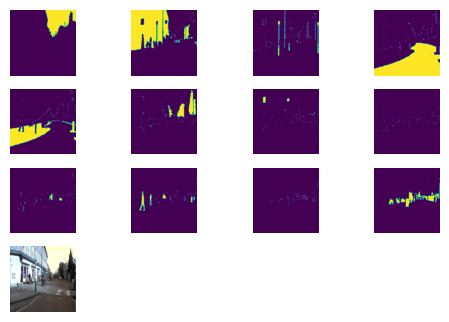

In [9]:
from matplotlib.gridspec import GridSpec
from random import randint, sample
ranidx = randint(0, len(y_train))
gs = GridSpec(4,4)
plt.figure(dpi=100)
for i in range(4*3):
    plt.subplot(gs[i]), plt.imshow(y_train[ranidx][:,:,i]), plt.axis('off')
    
plt.subplot(gs[12]), plt.imshow(X_train[ranidx]), plt.axis('off')

In [10]:
num_classes = 12
input_shape = X_train.shape[1:] #(480,480,3)
smooth = 1.
nproc = 8

In [11]:
from keras import backend as K
from keras.layers import Layer


class MaxPoolingWithArgmax2D(Layer):

    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        print("max pooling with argmax")
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        if K.backend() == 'tensorflow':
            ksize = [1, pool_size[0], pool_size[1], 1]
            padding = padding.upper()
            strides = [1, strides[0], strides[1], 1]
            output, argmax = tf.nn.max_pool_with_argmax(
                    inputs,
                    ksize=ksize,
                    strides=strides,
                    padding=padding)
        else:
            errmsg = '{} backend is not supported for layer {}'.format(
                    K.backend(), type(self).__name__)
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        print("i guess its subsampling")
        ratio = (1, 2, 2, 1)
        output_shape = [
                dim//ratio[idx]
                if dim is not None else None
                for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]


    def compute_mask(self, inputs, mask=None):
        print("no idea what this is: but computing mask")
        return 2 * [None]


class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        # one is pool and one is mask
        updates, mask = inputs[0], inputs[1]

        with tf.variable_scope(self.name):
            mask = K.cast(mask, 'int32')
            input_shape = tf.shape(updates, out_type='int32')     # it gives a dynamic shape of a given tensor. 

            #  calculation new shape
            if output_shape is None:
                output_shape = (
                        input_shape[0],
                        input_shape[1]*self.size[0],
                        input_shape[2]*self.size[1],
                        input_shape[3])
            self.output_shape1 = output_shape

            # calculation indices for batch, height, width and feature maps
            one_like_mask = K.ones_like(mask, dtype='int32')      #creates ones of the same shape as the mask
            batch_shape = K.concatenate([[input_shape[0]], [1], [1], [1]], axis=0)
            batch_range = K.reshape(tf.range(output_shape[0], dtype='int32'),shape=batch_shape)
            b = one_like_mask * batch_range

            y = mask // (output_shape[2] * output_shape[3])

            x = (mask // output_shape[3]) % output_shape[2]

            feature_range = tf.range(output_shape[3], dtype='int32')

            f = one_like_mask * feature_range

            # transpose indices & reshape update values to one dimension
            updates_size = tf.size(updates)       # Prints the number of elements in the updates
            indices = K.transpose(K.reshape(K.stack([b, y, x, f]), [4, updates_size]))
            values = K.reshape(updates, [updates_size])
            ret = tf.scatter_nd(indices, values, output_shape)
            return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
                mask_shape[0],
                mask_shape[1]*self.size[0],
                mask_shape[2]*self.size[1],
                mask_shape[3]
                )

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Reshape, Dense
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D

def segnet(
        input_shape,
        n_labels,
        kernel=3,
        pool_size=(2, 2),
        output_mode="softmax"):
    # encoder
    inputs = Input(shape=input_shape)

    conv_1 = Conv2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block1_conv1")(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Conv2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block1_conv2")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)
    pool_1 = MaxPooling2D(pool_size=pool_size, name="block1_pool")(conv_2)

    conv_3 = Conv2D(128, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block2_conv1")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Conv2D(128, (kernel, kernel), padding="same", kernel_initializer='he_normal',  name="block2_conv2")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)
    pool_2 = MaxPooling2D(pool_size=pool_size, name="block2_pool")(conv_4)

    conv_5 = Conv2D(256, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block3_conv1")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Conv2D(256, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block3_conv2")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)
    conv_7 = Conv2D(256, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block3_conv3")(conv_6)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)
    pool_3 = MaxPooling2D(pool_size=pool_size, name="block3_pool")(conv_7)

    conv_8 = Conv2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block4_conv1")(pool_3)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    conv_9 = Conv2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block4_conv2")(conv_8)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Activation("relu")(conv_9)
    conv_10 = Conv2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block4_conv3")(conv_9)
    conv_10 = BatchNormalization()(conv_10)
    conv_10 = Activation("relu")(conv_10)
    pool_4 = MaxPooling2D(pool_size=pool_size, name="block4_pool")(conv_10)

    conv_11 = Conv2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block5_conv1")(pool_4)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
    conv_12 = Conv2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal',  name="block5_conv2")(conv_11)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation("relu")(conv_12)
    conv_13 = Conv2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal',  name="block5_conv3")(conv_12)
    conv_13 = BatchNormalization()(conv_13)
    conv_13 = Activation("relu")(conv_13)
    pool_5 = MaxPooling2D(pool_size=pool_size, name="block5_pool")(conv_13)
   
    # decoder
    unpool_1 = UpSampling2D(size=pool_size)(pool_5)

    conv_14 = Conv2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    conv_15 = Conv2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation("relu")(conv_15)
    conv_16 = Conv2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation("relu")(conv_16)

    unpool_2 = UpSampling2D(size=pool_size)(conv_16)

    conv_17 = Conv2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_18 = Conv2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_17)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation("relu")(conv_18)
    conv_19 = Conv2D(256, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_18)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)

    unpool_3 = UpSampling2D(size=pool_size)(conv_19)

    conv_20 = Conv2D(256, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_3)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Conv2D(256, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation("relu")(conv_21)
    conv_22 = Conv2D(128, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_21)
    conv_22 = BatchNormalization()(conv_22)
    conv_22 = Activation("relu")(conv_22)

    unpool_4 = UpSampling2D(size=pool_size)(conv_22)

    conv_23 = Conv2D(128, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_4)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Conv2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation("relu")(conv_24)

    unpool_5 = UpSampling2D(size=pool_size)(conv_24)

    conv_25 = Conv2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_5)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation("relu")(conv_25)

    conv_26 = Conv2D(n_labels, (1, 1), padding="same", kernel_initializer='he_normal')(conv_25)
    conv_26 = BatchNormalization()(conv_26)

    conv_26 = Dense(12)(conv_26)
    outputs = Activation(output_mode)(conv_26)
    print("Build decoder done..")

    model = Model(inputs=inputs, outputs=outputs, name="SegNet")

    return model


In [13]:
model= segnet(input_shape=input_shape, n_labels=12)  #, single_model 

Build decoder done..


In [14]:
model.summary()

Model: "SegNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 224, 224, 64)      0         
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                            

                                                                 
 batch_normalization_15 (Bat  (None, 14, 14, 512)      2048      
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 14, 14, 512)       0         
                                                                 
 up_sampling2d_1 (UpSampling  (None, 28, 28, 512)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 512)       2359808   
                                                                 
 batch_normalization_16 (Bat  (None, 28, 28, 512)      2048      
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 28, 28, 512)       0         
          

In [15]:
VGG16_MODEL=tf.keras.applications.VGG16(include_top=False, weights='imagenet')

In [16]:
VGG16_MODEL.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [17]:
from tensorflow.keras.layers import Conv2D
layers = model.layers
merged_layers = []
count = 1
for _layer in layers:
  if isinstance(_layer, Conv2D):
    merged_layers.append(_layer)
  if _layer.name == "block5_pool":
    break

vgg_layer =[]
vgg_layers = VGG16_MODEL.layers
for _layer in vgg_layers:
  if isinstance(_layer, Conv2D):
    vgg_layer.append(_layer)

for seg_model, vgg_model in zip(merged_layers, vgg_layer):
  wk0 = vgg_model.get_weights()
  seg_model.set_weights(wk0)



In [18]:
import tensorflow as tf
sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer='sgd', metrics=['acc'])

In [19]:
history = model.fit(X_train, y_train,
                    batch_size=12,    # Reduced batch size
                    epochs=12,       # Fixed number of epochs
                    shuffle=True,
                    validation_split=0.1)


Epoch 1/12
36/36 [==============================] - 413s 11s/step - loss: 1.8703 - acc: 0.4739 - val_loss: 2.4469 - val_acc: 0.2006
Epoch 2/12
36/36 [==============================] - 394s 11s/step - loss: 1.2373 - acc: 0.7196 - val_loss: 1.9736 - val_acc: 0.5216
Epoch 3/12
36/36 [==============================] - 394s 11s/step - loss: 1.0311 - acc: 0.7581 - val_loss: 1.5378 - val_acc: 0.6557
Epoch 4/12
36/36 [==============================] - 396s 11s/step - loss: 0.9147 - acc: 0.7802 - val_loss: 1.1695 - val_acc: 0.7325
Epoch 5/12
36/36 [==============================] - 396s 11s/step - loss: 0.8425 - acc: 0.7952 - val_loss: 1.0295 - val_acc: 0.7417
Epoch 6/12
36/36 [==============================] - 394s 11s/step - loss: 0.7886 - acc: 0.8051 - val_loss: 0.8885 - val_acc: 0.7758
Epoch 7/12
36/36 [==============================] - 393s 11s/step - loss: 0.7405 - acc: 0.8159 - val_loss: 0.8640 - val_acc: 0.7704
Epoch 8/12
36/36 [==============================] - 394s 11s/step - loss: 0.

In [20]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [21]:
model.evaluate(X_test, y_test)

8/8 [==============================] - 42s 5s/step - loss: 0.9640 - acc: 0.7406


[0.9640184044837952, 0.7405958771705627]

In [23]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Example ground truth and predictions
y_true = np.array([1, 0, 1, 1, 0, 1])
y_pred = np.array([1, 1, 0, 1, 0, 1])

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Accuracy: 0.6667
Precision: 0.7500
Recall: 0.7500
F1 Score: 0.7500


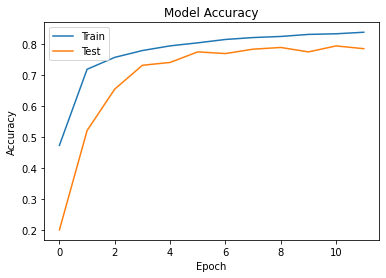

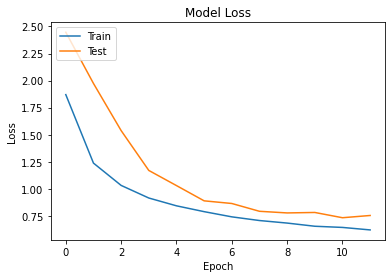

In [24]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
     

8/8 [==============================] - 44s 5s/step


(<Figure size 432x288 with 1 Axes>,
 (-0.5, 223.5, 223.5, -0.5))

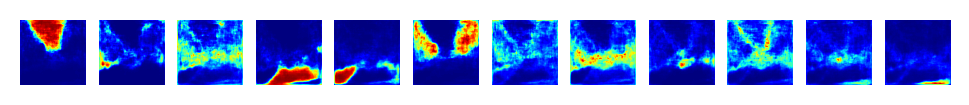

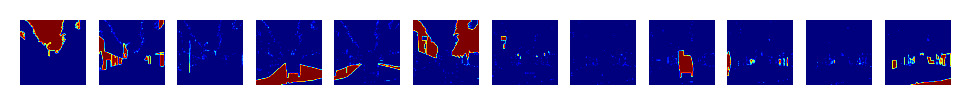

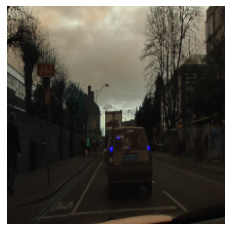

In [25]:
pred = model.predict(X_test, verbose=1)

ranidx = randint(0, len(y_test))
gs = GridSpec(1,12)
plt.figure(dpi=200)
for i in range(12):
    plt.subplot(gs[i]), plt.imshow(pred[ranidx][:,:,i], cmap='jet'), plt.axis('off')

plt.figure(dpi=200)
for i in range(12):
    plt.subplot(gs[i]), plt.imshow(y_test[ranidx][:,:,i],cmap='jet'), plt.axis('off')
    
plt.figure(),plt.imshow(X_test[ranidx]), plt.axis('off')